# 1. Overview

This is Exploratory Data Analysis for <a href='https://www.kaggle.com/competitions/recruit-restaurant-visitor-forecasting/overview'>Recruit Restaurant Visitor Forecasting</a> competition on Kaggle.

Restaurants need to know how many are expected each day to effectively plan for resources such as ingredients and staff members. 

The goal is to predict the number of visitors for specified future dates based on data Recruit Holdings have from their products, such as Hot Pepper Gourmet (restaurant review/reservation platform), AirREGI (POS cash register used at restaurants), Restaurant Board (reservation management).

# 2. Datasets
- `air_reserve.csv`
- `hpg_reserve.csv`
- `air_store_info.csv`
- `hpg_store_info.csv`
- `store_id_relation.csv`
- `air_visit_data.csv`
- `sample_submission.csv`
- `date_info.csv`

1. `air_reserve.csv`: This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.
    - air_store_id - the restaurant's id in the air system
    - visit_datetime - the time of the reservation
    - reserve_datetime - the time the reservation was made
    - reserve_visitors - the number of visitors for that reservation
2. `hpg_reserve.csv`: This file contains reservations made in the hpg system.
    - hpg_store_id - the restaurant's id in the hpg system
    - visit_datetime - the time of the reservation
    - reserve_datetime - the time the reservation was made
    - reserve_visitors - the number of visitors for that reservation
3. `air_store_info.csv`: This file contains information about select air restaurants. Column names and contents are self-explanatory
    - air_store_id
    - air_genre_name
    - air_area_name
    - latitude
    - longitude
    Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
4. `hpg_store_info.csv`: This file contains information about select hpg restaurants. Column names and contents are self-explanatory.
    - hpg_store_id
    - hpg_genre_name
    - hpg_area_name
    - latitude
    - longitude
    Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
5. `store_id_relation.csv`: This file allows you to join select restaurants that have both the air and hpg system.
    - hpg_store_id
    - air_store_id
6. `air_visit_data.csv`: This file contains historical visit data for the air restaurants.
    - air_store_id
    - visit_date - the date
    - visitors - the number of visitors to the restaurant on the date
7. `sample_submission.csv`: This file shows a submission in the correct format, including the days for which you must forecast.
    - id - the id is formed by concatenating the air_store_id and visit_date with an underscore
    - visitors- the number of visitors forecasted for the store and date combination
8. `date_info.csv`: This file gives basic information about the calendar dates in the dataset. 
    - calendar_date
    - day_of_week
    - holiday_flg - is the day a holiday in Japan

# 3. Load data and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
air_reserve = pd.read_csv('data/air_reserve.csv', parse_dates=['reserve_datetime', 'visit_datetime'])
hpg_reserve = pd.read_csv('data/hpg_reserve.csv', parse_dates=['reserve_datetime', 'visit_datetime'])
air_store_info = pd.read_csv('data/air_store_info.csv')
hpg_store_info = pd.read_csv('data/hpg_store_info.csv')
store_id_relation = pd.read_csv('data/store_id_relation.csv')
air_visit_data = pd.read_csv('data/air_visit_data.csv', parse_dates=['visit_date'])
date_info = pd.read_csv('data/date_info.csv', parse_dates=['calendar_date'])
sample_df = pd.read_csv('data/sample_submission.csv')

# 4. What needs to be predicted? - `sample_df`
- Sample submission data contains:
  - 821 restaurants (`air_store_id`)
  - dates from 23 Apr 2017 to 31 May 2017 (39 days)

In [3]:
sample_df.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [63]:
# split column id into air_store_id and visit_date
split_cols = sample_df.id.str.split('([a-z0-9_]{20})_', expand=True, regex=True)
sample_df_new = pd.concat([sample_df, split_cols.loc[:, 1:]], axis=1)
sample_df_new = sample_df_new.rename(columns={1: 'air_store_id', 2: 'date'}).drop(['id', 'visitors'], axis=1)
sample_df_new.date = pd.to_datetime(sample_df_new.date)
sample_df_new.head()

,air_store_id,date
0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9,2017-04-27


In [5]:
print(f'Number of unique IDs in submission sample is {len(sample_df_new.air_store_id.unique())}')

Number of unique IDs in submission sample is 821


In [6]:
sample_df_new.air_store_id.value_counts(sort=True)

air_store_id
air_00a91d42b08b08d9    39
air_a9a380530c1e121f    39
air_a55d17bd3f3033cb    39
air_a563896da3777078    39
air_a678e5b144ca24ce    39
                        ..
air_5dea8a7a5bf5eb71    39
air_5e339a1f364cdb00    39
air_5e34c6fe6fabd10e    39
air_5e70fe82f9e4fab6    39
air_fff68b929994bfbd    39
Name: count, Length: 821, dtype: int64

In [7]:
sample_df_new.date.min(), sample_df_new.date.max()

('2017-04-23', '2017-05-31')

# 5. Number of stores represented in each dataframe

In [8]:
print(f'''
    number of unique air_store_ids in:
    air_reserve: {len(air_reserve.air_store_id.unique())},
    air_store_info: {len(air_store_info.air_store_id.unique())},
    air_visit_data: {len(air_visit_data.air_store_id.unique())},
    sample_df: {len(sample_df_new.air_store_id.unique())},
    store_id_relation: {len(store_id_relation.air_store_id.unique())}

    number of unique hpg_store_ids in:
    hpg_reserve: {len(hpg_reserve.hpg_store_id.unique())},
    hpg_store_info: {len(hpg_store_info.hpg_store_id.unique())},
    store_id_relation: {len(store_id_relation.hpg_store_id.unique())}
    ''')


    number of unique air_store_ids in:
    air_reserve: 314,
    air_store_info: 829,
    air_visit_data: 829,
    sample_df: 821,
    store_id_relation: 150

    number of unique hpg_store_ids in:
    hpg_reserve: 13325,
    hpg_store_info: 4690,
    store_id_relation: 150
    


In [55]:
print(f'''
      number of ids that overlaps with sample_df:
      air_reserve: {len(air_reserve[air_reserve.air_store_id.isin(sample_df_new.air_store_id)].air_store_id.unique())},
      air_store_info: {len(air_store_info[air_store_info.air_store_id.isin(sample_df_new.air_store_id)].air_store_id.unique())},
      air_visit_data: {len(air_visit_data[air_visit_data.air_store_id.isin(sample_df_new.air_store_id)].air_store_id.unique())}
      ''')


      number of ids that overlaps with sample_df:
      air_reserve: 314,
      air_store_info: 821,
      air_visit_data: 821
      


# 6. `air_visit_data`
- Contains data from 1 Jan 2016 to 22 Apr 2017 (478 days)
- most restaurants have no data until July 2016 
    - 750 restaurants have data on 1 Jul 2016 (vs. 290 on 30 Jun 2016)
- There's a regular pattern in missing data (weekly?) and there's a bigger patch of missing data around Obon holidays and new year time
- Correlation between dates with the same day of the week (.7+)
- Number of visitors seem to peak on weekends

In [10]:
# pivot dataframe
air_visit_data_pivoted = air_visit_data[air_visit_data.air_store_id.isin(sample_df_new.air_store_id)].pivot(columns='visit_date', index='air_store_id', values='visitors')

## 6.1. Time scope

In [11]:
print(f'scope of visit data: {air_visit_data.visit_date.min()} ~ {air_visit_data.visit_date.max()}')

scope of visit data: 2016-01-01 00:00:00 ~ 2017-04-22 00:00:00


In [12]:
from datetime import timedelta
air_visit_data.visit_date.max() - air_visit_data.visit_date.min() + timedelta(days=1)

Timedelta('478 days 00:00:00')

## 6.2. Missing data

In [13]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


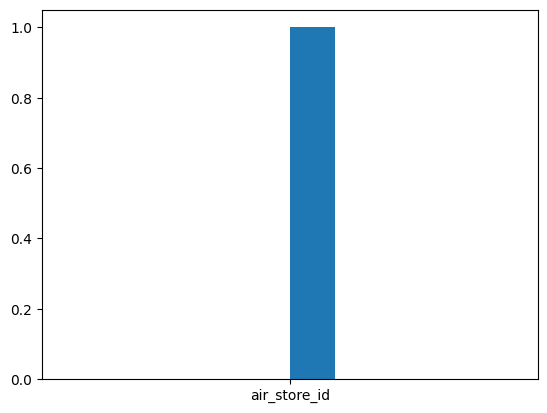

In [14]:
# number of data points for per ID - distribution
air_visit_data_count = pd.DataFrame(air_visit_data.dropna().air_store_id.value_counts()).rename(columns={'count':'data_points'})
plt.hist('air_store_id', data=air_visit_data_count)
plt.show()

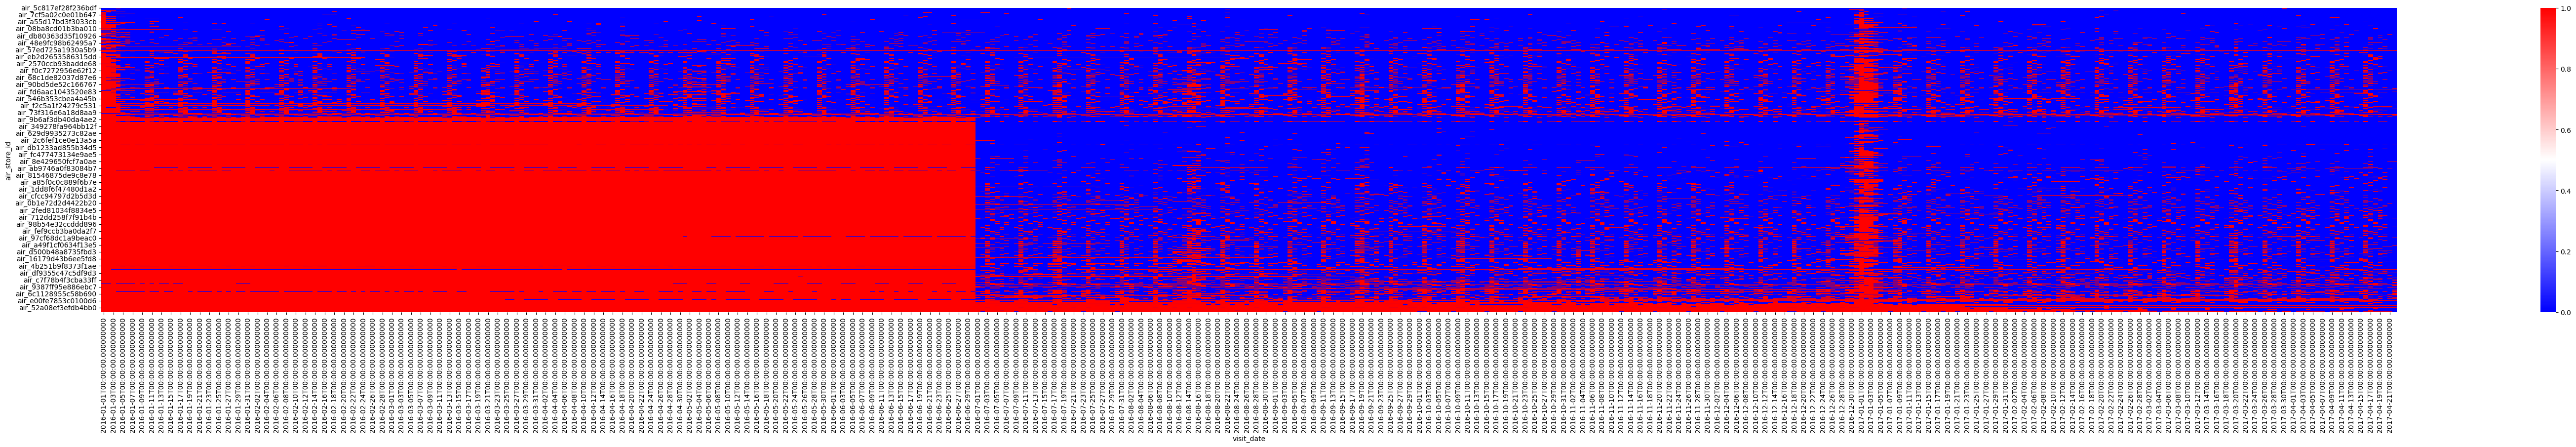

In [15]:
# Missing data by date
fig, ax = plt.subplots(figsize=(75,8))
sorter = air_visit_data.groupby('air_store_id').agg({'visitors':'count'}).sort_values('visitors', ascending=False).index

sns.heatmap(air_visit_data_pivoted.reindex(sorter).isna(), cmap='bwr')
fig.show()

In [16]:
# missing data on 1 Jul 2016
air_visit_data_pivoted.isna()['2016-07-01'].value_counts()

2016-07-01 00:00:00
False    750
True      71
Name: count, dtype: int64

In [17]:
# missing data on 30 Jun 2016
air_visit_data_pivoted.isna()['2016-06-30'].value_counts()

2016-06-30 00:00:00
True     531
False    290
Name: count, dtype: int64

## 6.3. Correlation between dates (latest 30 days)

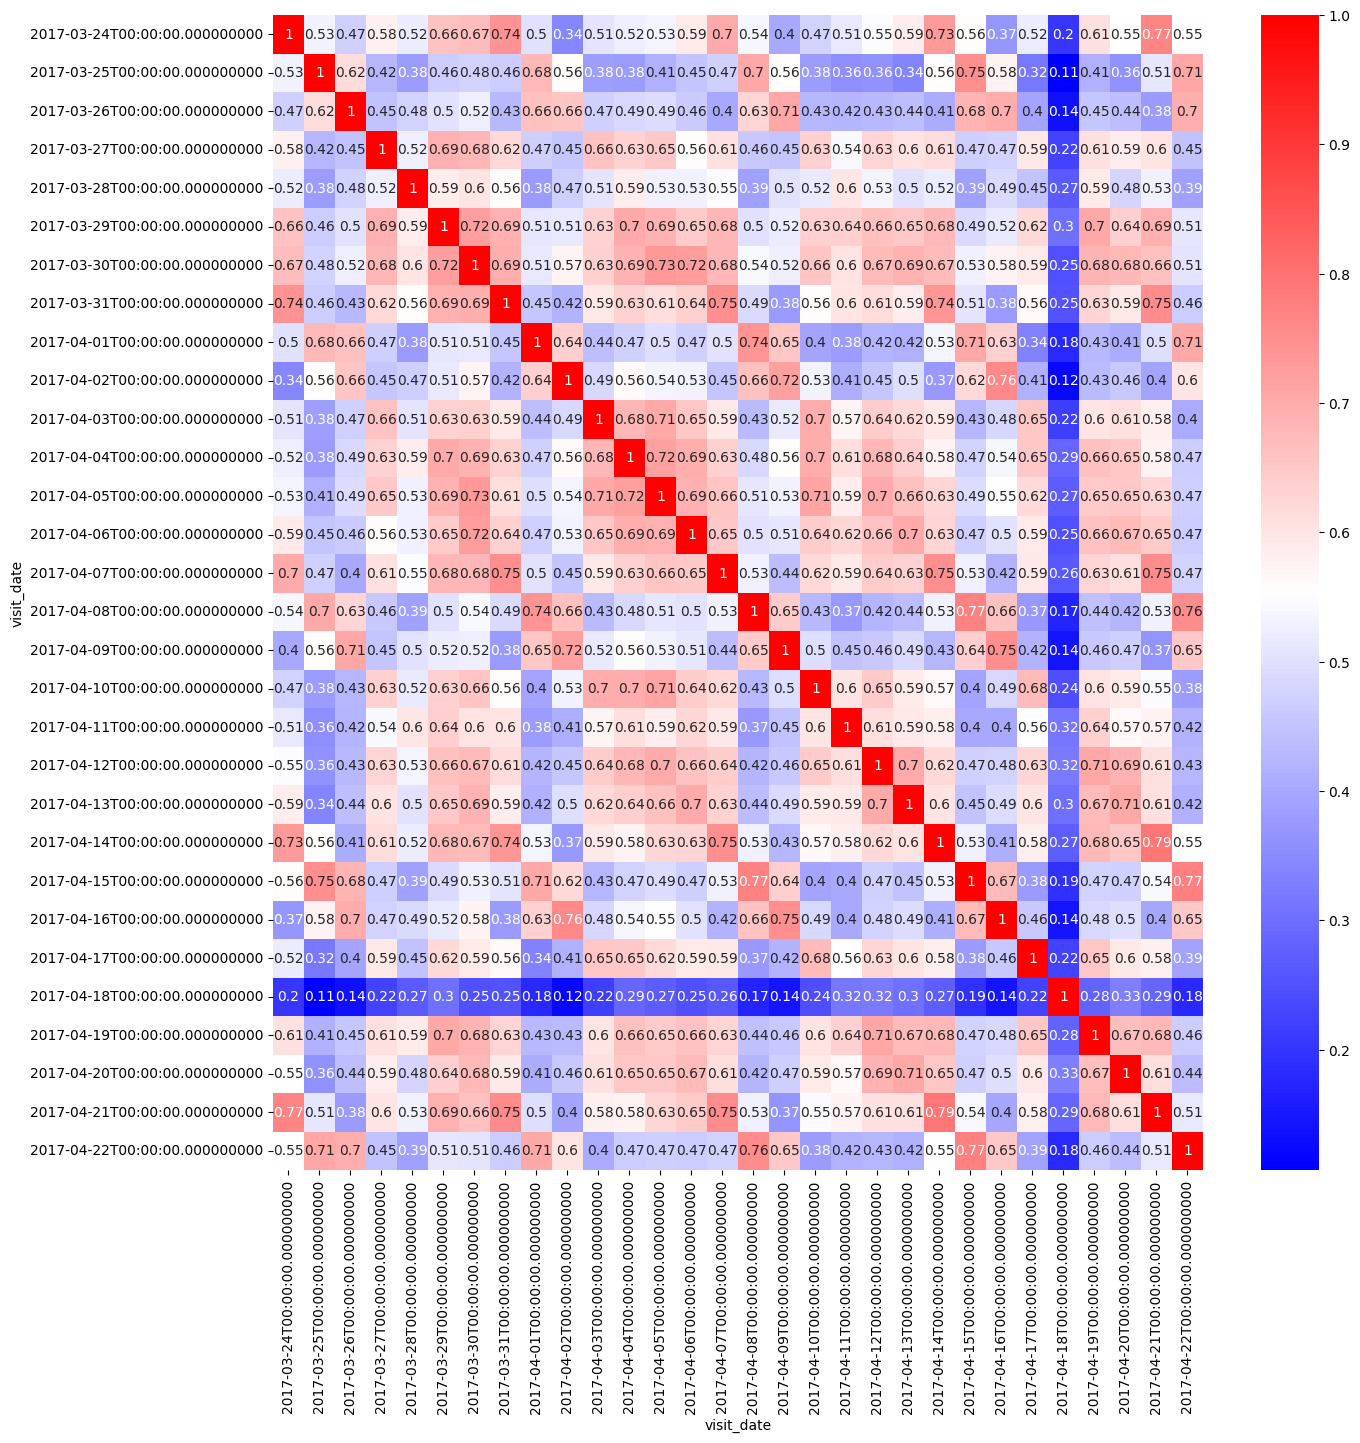

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(air_visit_data_pivoted.iloc[:,-30:].corr(), cmap='bwr', annot=True)
fig.show()

## 6.4 Visualising the Number of visitors

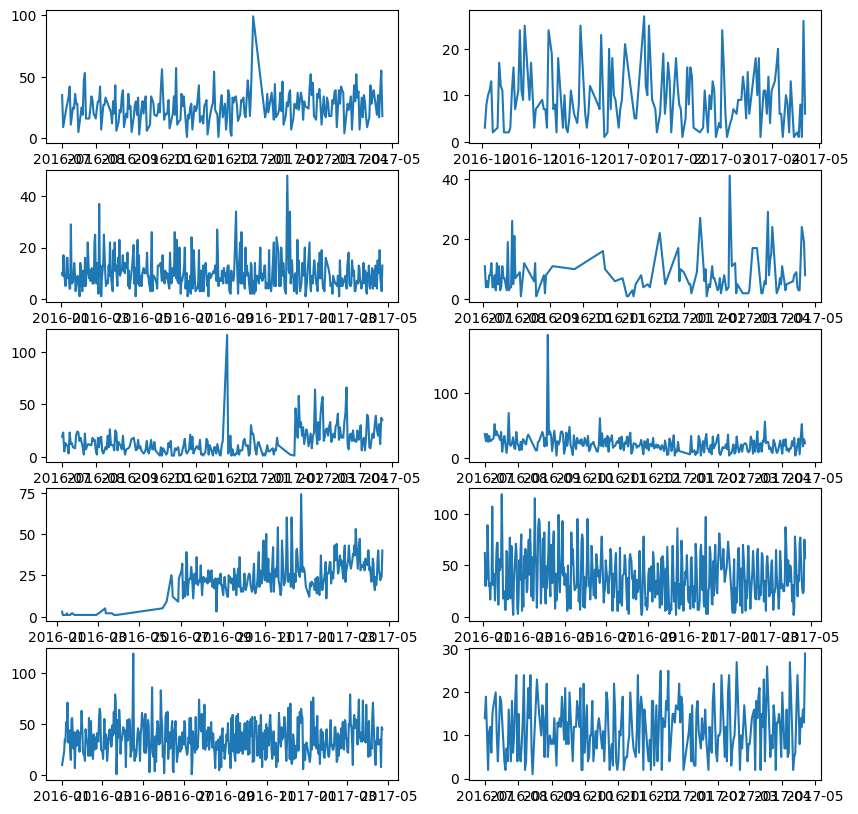

In [19]:
# 10 restaurants with highest number of data points
fig, ax = plt.subplots(5, 2, figsize=(10,10))

for i in range(10):
    x = i//2
    y = i%2
    ax[x, y].plot(
        'visit_date',
        'visitors',
        data=air_visit_data[air_visit_data.air_store_id==air_visit_data.groupby('air_store_id').agg({'visitors':'count'}).index[i]],
        )

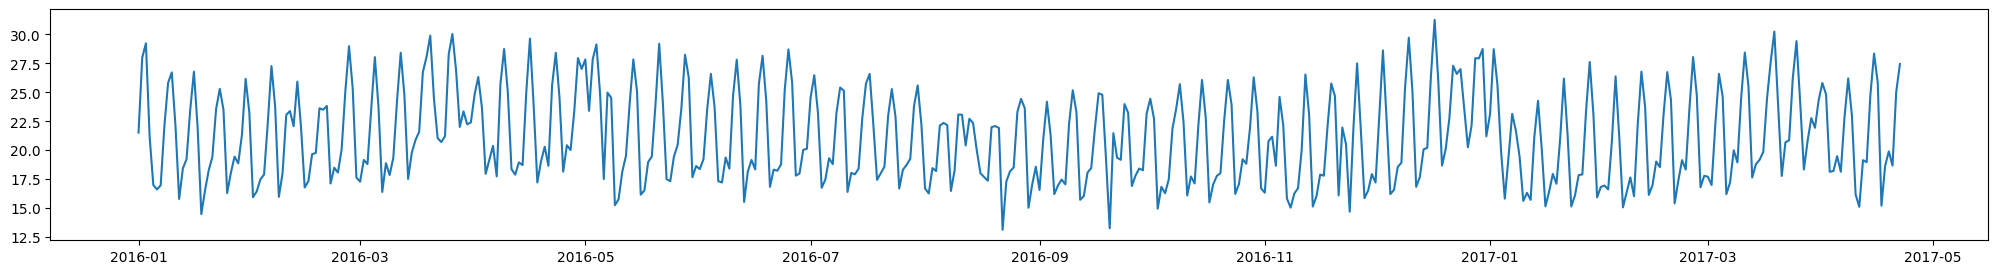

In [20]:
# average number of visitors
air_visit_data_mean = air_visit_data.groupby('visit_date').agg({'visitors':'mean'})
plt.figure(figsize=(25, 3))
plt.plot('visitors', data=air_visit_data_mean)

# 7. Reservations + visitors

- There's a high correlation (.90+) between the sum of reserved visitors and the sum of actual visitors in both `air` and `hpg`

In [116]:
air_reserve['visit_date'] = pd.to_datetime(air_reserve.visit_datetime.dt.date)
hpg_reserve['visit_date'] = pd.to_datetime(hpg_reserve.visit_datetime.dt.date)

In [124]:
# left join reservation and visit data to the sample submission file
reserve_visit_combined = pd.DataFrame(sample_df_new.air_store_id.unique()).rename(columns={0:'air_store_id'}).join(
        store_id_relation.set_index('air_store_id'), on='air_store_id', how='left'
    ).join(
        air_visit_data.set_index('air_store_id'), on='air_store_id', how='left'
    ).join(
        air_reserve.set_index(['air_store_id', 'visit_date']).drop(columns=['visit_datetime', 'reserve_datetime']), on=['air_store_id', 'visit_date'], how='left'
    ).join(
        hpg_reserve.set_index(['hpg_store_id', 'visit_date']).drop(columns=['visit_datetime', 'reserve_datetime']), on=['hpg_store_id', 'visit_date'], how='left', lsuffix='_air', rsuffix='_hpg'
    )

In [131]:
reserve_visit_combined.head()

,air_store_id,hpg_store_id,visit_date,visitors,reserve_visitors_air,reserve_visitors_hpg
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-01,35,NaN,1.0
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-02,9,NaN,NaN
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-04,20,NaN,NaN
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-05,25,NaN,NaN
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-06,29,NaN,7.0


In [132]:
reserve_visit_combined_daily = reserve_visit_combined.groupby('visit_date').agg({'visitors':'sum', 'reserve_visitors_air':'sum', 'reserve_visitors_hpg':'sum'})
reserve_visit_combined_daily.head()

,visitors,reserve_visitors_air,reserve_visitors_hpg
visit_date,,,
2016-01-01,979,17.0,4.0
2016-01-02,3846,150.0,54.0
2016-01-03,2805,53.0,34.0
2016-01-04,3798,122.0,23.0
2016-01-05,4021,76.0,11.0


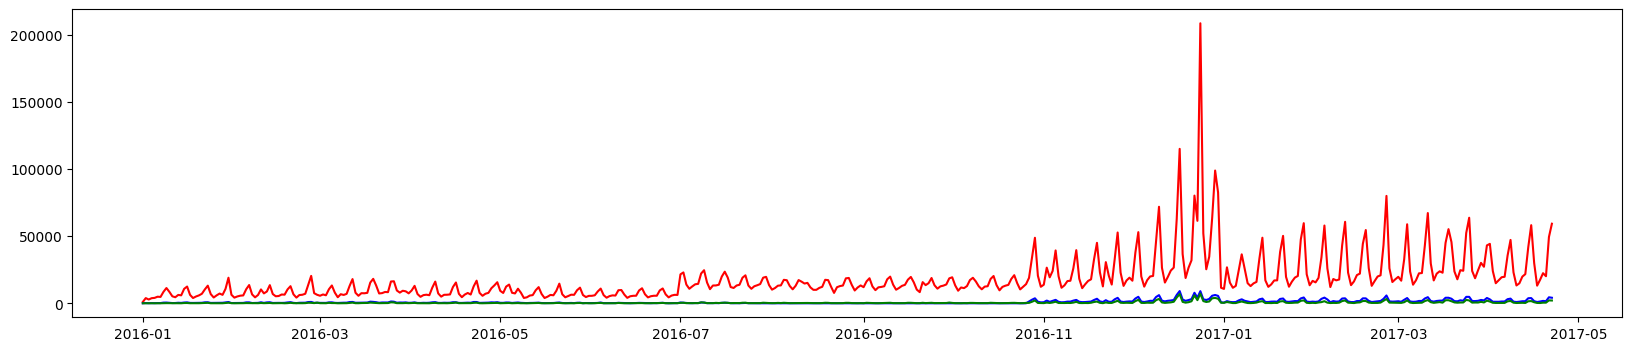

In [134]:
plt.figure(figsize=(20,4))
plt.plot('visitors', 'red', data=reserve_visit_combined_daily)
plt.plot('reserve_visitors_air', 'blue', data=reserve_visit_combined_daily)
plt.plot('reserve_visitors_hpg', 'green', data=reserve_visit_combined_daily)
plt.show()

In [135]:
reserve_visit_combined_daily.corr()

,visitors,reserve_visitors_air,reserve_visitors_hpg
visitors,1.000000,0.905736,0.941491
reserve_visitors_air,0.905736,1.000000,0.927963
reserve_visitors_hpg,0.941491,0.927963,1.000000


# 8. `date_info` and visitor data
- Fridays, Saturdays and Sundays see the highest average number of visitors, with the peak on Saturdays
- Holidays on average see a higher number of visitors than non-holidays

In [32]:
air_visit_data_with_date_info = air_visit_data.join(date_info.set_index('calendar_date'), on='visit_date', how='left')

In [33]:
air_visit_data_with_date_info

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0
...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,0
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,0


In [34]:
day_visitors = air_visit_data_with_date_info.groupby('day_of_week').agg({'visitors':'mean'}).reset_index()
day_visitors.day_of_week = pd.Categorical(day_visitors.day_of_week, categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
day_visitors.sort_values('day_of_week', inplace=True)

<BarContainer object of 7 artists>

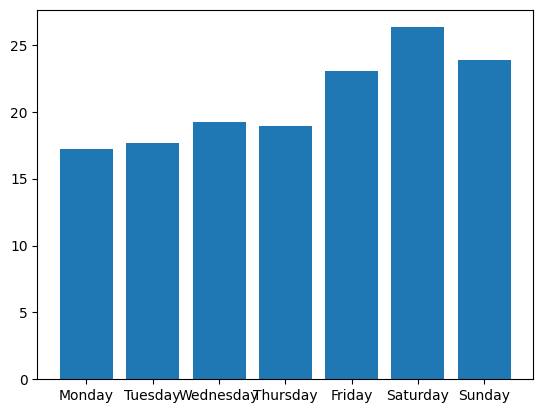

In [35]:
# average number of visitors by day of week
plt.bar('day_of_week', 'visitors', data=day_visitors)

<BarContainer object of 2 artists>

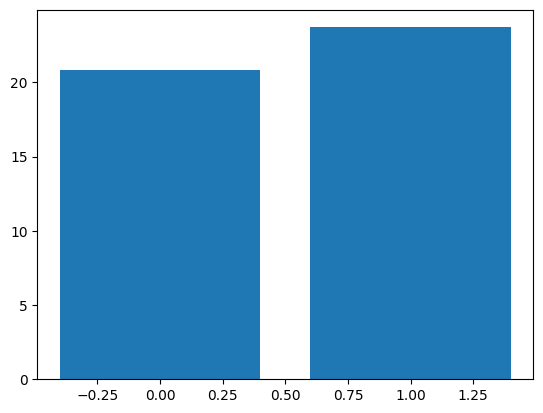

In [36]:
holiday_visitors = air_visit_data_with_date_info.groupby('holiday_flg').agg({'visitors':'mean'}).reset_index()
plt.bar('holiday_flg', 'visitors', data=holiday_visitors)